In [11]:
%matplotlib inline  
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dateutil
import random
import math

In this problem, we will try to predict
a movie's genre from the text of its screenplay. We have compiled a list of 5,000 words that occur in conversations between movie characters. For each movie, our dataset tells us the frequency with which each of these words occurs in certain conversations in its screenplay. All words have been converted to lowercase.

Run the cell below to read the `movies` table. It may take up a minute or so to load.

In [12]:
movies = pd.read_csv('https://github.com/YData123/sds265-fa22/raw/master/assignments/assn1/movies.csv')
movies.head(10)

,Title,Genre,Year,Rating,# Votes,# Words,i,the,to,a,...,foster,pub,vegetarian,garrison,grammoo,chimney,bikini,richter,psychopath,fling
0,the terminator,action,1984,8.1,183538,1849,0.040022,0.043807,0.025419,0.024878,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,batman,action,1989,7.6,112731,2836,0.051481,0.033850,0.023977,0.028209,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,tomorrow never dies,action,1997,6.4,47198,4215,0.028707,0.054330,0.030368,0.021827,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000237,0.0
3,batman forever,action,1995,5.4,77223,3032,0.036609,0.042216,0.020449,0.031003,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,supergirl,action,1984,4.1,6576,3842,0.041905,0.032275,0.028891,0.026288,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
5,the avengers,action,1998,3.4,21519,3586,0.036810,0.033463,0.024819,0.029002,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000279,0.0
6,natural born killers,action,1994,7.1,73047,5129,0.028271,0.047378,0.022032,0.027296,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
7,airplane ii: the sequel,romance,1982,5.8,15210,2328,0.027921,0.048969,0.035223,0.025773,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
8,willow,romance,1988,7.1,33506,2006,0.038883,0.028913,0.030409,0.030409,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
9,fast times at ridgemont high,romance,1982,7.2,31710,4703,0.047629,0.027217,0.030619,0.018711,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [13]:
movies.iloc[123,[0, 1, 2, 3, 4, 5, 10, 30, 5005]]

Title      the matrix
Genre          action
Year             1999
Rating            8.7
# Votes        389480
# Words          3792
it           0.030327
not          0.008703
fling             0.0
Name: 123, dtype: object

The above cell prints a few columns of the row for the action movie *The Matrix*.  The movie contains 3792 words. The word "it" appears 115 times, as it makes up a fraction $\frac{115}{3792} \approx 0.030327$ of the words in the movie. The word "not" appears 33 times, as it makes up a fraction $\frac{33}{3792} \approx 0.00870253$ of the words. The word "fling" doesn't appear at all.

This numerical representation of a body of text, one that describes only the frequencies of individual words, is called a bag-of-words representation. A lot of information is discarded in this representation: the order of the words, the context of each word, who said what, the cast of characters and actors, etc. However, a bag-of-words representation is often used for machine learning applications as a reasonable starting point, because a great deal of information is also retained and expressed in a convenient and compact format. We will investigate whether this representation is sufficient to build an accurate genre classifier.

All movie titles are unique. The `row_for_title` function provides fast access to the one row for each title. 

In [14]:
def row_for_title(title):
    """Return the row for a title
    
    """
    return movies[movies["Title"]==title]

For example, the fastest way to find the frequency of "hey" in the movie *The Terminator* is to access the `'hey'` item from its row. Check the original table to see if this worked for you!

In [15]:
row_for_title('the terminator')["hey"].item()

0.000540833

This dataset was extracted from [a dataset from Cornell University](http://www.cs.cornell.edu/~cristian/Cornell_Movie-Dialogs_Corpus.html). After transforming the dataset (e.g., converting the words to lowercase, removing profanity, and converting the counts to frequencies), this new dataset was created containing the frequency of 5000 common words in each movie.

In [16]:
print('Words with frequencies:', len(movies.drop(movies.columns[np.arange(6)],axis=1).columns)) 
print('Movies with genres:', len(movies))

Words with frequencies: 5000
Movies with genres: 236


**Word Stemming**

The columns other than "Title", "Genre", "Year", "Rating", "# Votes" and "# Words" in the `movies` table are all words that appear in some of the movies in our dataset.  These words have been *stemmed*, or abbreviated heuristically, in an attempt to make different [inflected](https://en.wikipedia.org/wiki/Inflection) forms of the same base word into the same string.  For example, the column "manag" is the sum of proportions of the words "manage", "manager", "managed", and "managerial" (and perhaps others) in each movie. This is a common technique used in machine learning and natural language processing.

Stemming makes it a little tricky to search for the words you want to use, so we have provided another table that will let you see examples of unstemmed versions of each stemmed word.  Run the code below to load it.

In [17]:
# Just run this cell.
vocab_mapping = pd.read_csv('https://github.com/YData123/sds265-fa22/raw/master/assignments/assn1/stem.csv')
stemmed = list(movies.drop(movies.columns[np.arange(6)],axis=1).columns)
vocab_table = vocab_mapping[vocab_mapping["Stem"].isin(stemmed)]
vocab_table = vocab_table.sort_values('Stem')
vocab_table.iloc[np.arange(2000, 2010)]


,Stem,Word
25957,coloni,colonial
10851,coloni,colony
32608,coloni,colonies
2245,coloni,colonys
12087,columbia,columbia
37766,columbia,columbias
19615,column,column
1523,column,columns
12629,com,com
38458,coma,coma


Assign `stemmed_alternating` to the stemmed version of the word "alternating".

In [21]:
# Set stemmed_alternating to the stemmed version of "alternating" (which
# should be a string).  Use vocab_table.
stemmed_alternating = vocab_table[vocab_table["Word"]=='alternating']["Stem"].item()
stemmed_alternating

'altern'

Assign `unstemmed_run` to an array of words in `vocab_table` that have "run" as its stemmed form. 

In [22]:
# Set unstemmed_run to the unstemmed versions of "run" (which
# should be an array of string).
unstemmed_run = vocab_table.loc[vocab_table['Stem'] == 'run','Word'].values
unstemmed_run

array(['run', 'runs', 'running', 'runnings', 'runned'], dtype=object)

**Splitting the dataset**

We're going to use our `movies` dataset for two purposes.

1. First, we want to *train* a movie genre classifier.
2. Second, we want to *test* the performance of the classifier.

So, we need two different datasets: *training* and *test*.

The purpose of a classifier is to classify unseen data that is similar to the training data. Therefore, we must ensure that there are no movies that appear in both sets. We do so by splitting the dataset randomly. The dataset has already been permuted randomly, so it's easy to split.  We just take the top for training and the rest for test. 

Run the code below (without changing it) to separate the datasets into two tables.

In [23]:
# Here we have defined the proportion of our data
# that we want to designate for training as 17/20ths
# of our total dataset.  3/20ths of the data is
# reserved for testing.

training_proportion = 17/20

num_movies = len(movies)
num_train = int(num_movies * training_proportion)
num_test = num_movies - num_train

train_movies = movies.iloc[np.arange(num_train)]
test_movies = movies.iloc[np.arange(num_train, num_movies)]

print("Training: ",   len(train_movies), ";",
      "Test: ",       len(test_movies))

Training:  200 ; Test:  36


Draw a horizontal bar chart with two bars that show the proportion of Action movies in each dataset.  Complete the function `action_proportion` first; it should help you create the bar chart.

{'Training Data Proportion': 0.56, 'Testing Data Proportion': 0.5555555555555556}


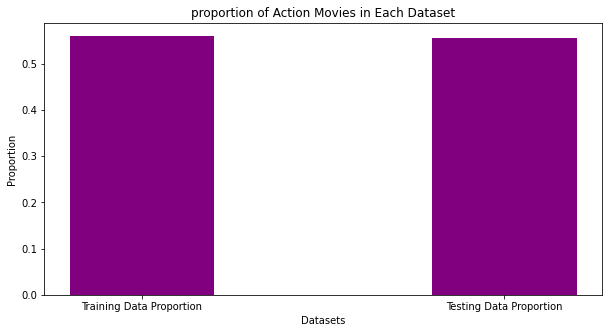

In [275]:
def action_proportion(dataframe):
    """Return the proportion of movies in a table that have the Action genre."""
    prop = len(dataframe[dataframe["Genre"]=='action'])/len(dataframe)
    return prop

train_test_action = {'Training Data Proportion':action_proportion(train_movies), 
                     'Testing Data Proportion':action_proportion(test_movies)}
data = list(train_test_action.keys())
proportion = list(train_test_action.values())

print(train_test_action)

fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(data, proportion, color ='purple',
        width = 0.4)
 
plt.xlabel("Datasets")
plt.ylabel("Proportion")
plt.title("proportion of Action Movies in Each Dataset")
plt.show()

K-Nearest Neighbors: 

**Classifying a movie**

In k-NN, we classify a movie by finding the `k` movies in the *training set* that are most similar according to the features we choose. We call those movies with similar features the *nearest neighbors*.  The k-NN algorithm assigns the movie to the most common category among its `k` nearest neighbors.

Let's limit ourselves to just 2 features for now, so we can plot each movie.  The features we will use are the proportions of the words "money" and "feel" in the movie.  Taking the movie "Batman Returns" (in the test set), 0.000502 of its words are "money" and 0.004016 are "feel". This movie appears in the test set, so let's imagine that we don't yet know its genre.

First, we need to make our notion of similarity more precise.  We will say that the *distance* between two movies is the straight-line distance between them when we plot their features in a scatter diagram. This distance is called the Euclidean ("yoo-KLID-ee-un") distance, whose formula is $\sqrt{(x_1 - x_2)^2 + (y_1 - y_2)^2}$.

For example, in the movie *Titanic* (in the training set), 0.0009768 of all the words in the movie are "money" and 0.0017094 are "feel".  Its distance from *Batman Returns* on this 2-word feature set is $$\sqrt{(0.000502 - 0.0009768)^2 + (0.004016 - 0.0017094)^2} \approx 0.00235496.$$  (If we included more or different features, the distance could be different.)

A third movie, *The Avengers* (in the training set), is 0 "money" and 0.001115 "feel".

The function below creates a plot to display the "money" and "feel" features of a test movie and some training movies. As you can see in the result, *Batman Returns* is more similar to *Titanic* than to *The Avengers* based on these features. However, we know that *Batman Returns* and *The Avengers* are both action movies, so intuitively we'd expect them to be more similar. Unfortunately, that isn't always the case. We'll discuss this more later.

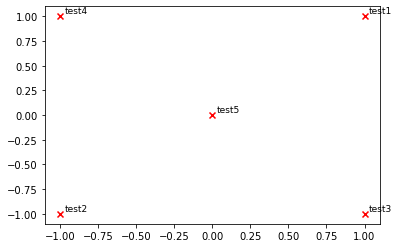

In [18]:
# Just run this cell.
def plot_embeddings(M_reduced, word2Ind, words):
    """ 
        Plot in a scatterplot the embeddings of the words specified in the list "words".
        Include a label next to each point.
    """
    for word in words:
        x, y = M_reduced[word2Ind[word]]
        plt.scatter(x, y, marker='x', color='red')
        plt.text(x+.03, y+.03, word, fontsize=9)
    plt.show()

M_reduced_plot_test = np.array([[1, 1], [-1, -1], [1, -1], [-1, 1], [0, 0]])
word2Ind_plot_test = {'test1': 0, 'test2': 1, 'test3': 2, 'test4': 3, 'test5': 4}
words = ['test1', 'test2', 'test3', 'test4', 'test5']
plot_embeddings(M_reduced_plot_test, word2Ind_plot_test, words)

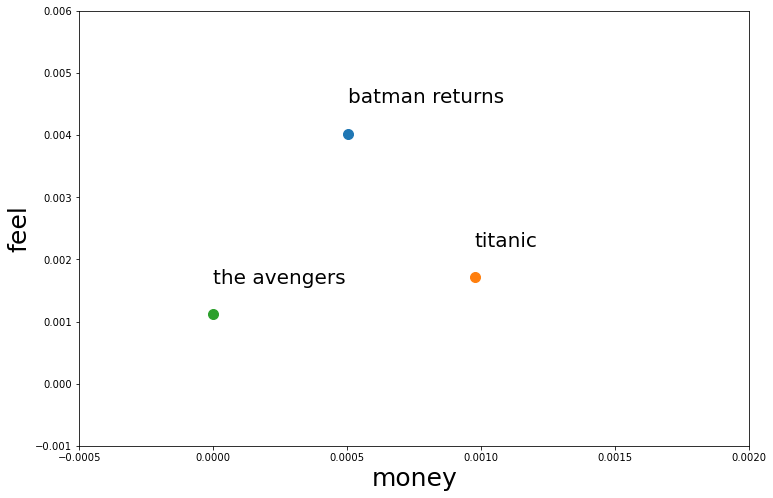

In [19]:
# Just run this cell.
def plot_with_two_features(test_movie, training_movies, x_feature, y_feature):
    """Plot a test movie and training movies using two features."""
    test_row = row_for_title(test_movie)
    test_x = test_row[x_feature].item()
    test_y = test_row[y_feature].item()
    plt.scatter(test_x, test_y, s=100)
    plt.text(test_x, test_y+.0005, test_movie, fontsize=20)
    for movie in training_movies:
        row = row_for_title(movie)
        train_x = row[x_feature].item()
        train_y = row[y_feature].item()
        plt.scatter(train_x, train_y, s=100)
        plt.text(train_x, train_y+.0005, movie, fontsize=20)
    plt.show()
    
plt.figure(figsize=(12, 8))
plt.xlim(-0.0005, 0.002)
plt.ylim(-0.001, 0.006)
plt.xlabel('money', fontsize=25)
plt.ylabel('feel', fontsize=25)

training = ["titanic", "the avengers"]
plot_with_two_features("batman returns", training, "money", "feel")



Compute the distance between the two action movies, *Batman Returns* and *The Avengers*, using the `money` and `feel` features only.  Assign it the name `action_distance`.

**Note:** If you have a row, you can use `item` to get a value from a column by its name.  For example, if `r` is a row, then `r["Genre"].item()` is the value in column `"Genre"` in row `r`.

*Hint*: Remember the function `row_for_title`, redefined for you below. 

In [27]:
def row_for_title(title):
    """Return the row for a title
    
    """
    return movies[movies["Title"]==title]

In [276]:
batman = row_for_title("batman returns")
avengers = row_for_title("the avengers")
action_distance = ((batman['feel'].item()-avengers['feel'].item())**2+
                   (batman['money'].item()-avengers['money'].item())**2)
action_distance

8.665579410288998e-06

Below, we've added a third training movie, *The Terminator*. Before, the point closest to *Batman Returns* was *Titanic*, a romance movie. However, now the closest point is *The Terminator*, an action movie.

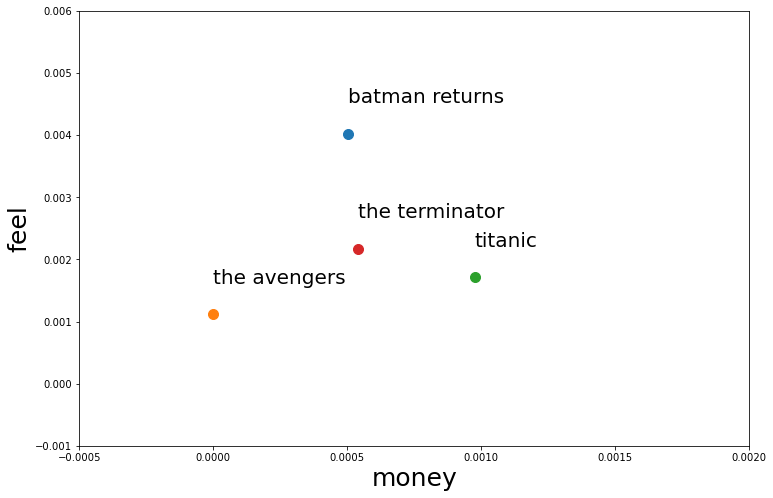

In [29]:
plt.figure(figsize=(12, 8))
plt.xlim(-0.0005, 0.002)
plt.ylim(-0.001, 0.006)
plt.xlabel('money', fontsize=25)
plt.ylabel('feel', fontsize=25)

training = ["the avengers", "titanic", "the terminator"] 
plot_with_two_features("batman returns", training, "money", "feel") 



Complete the function `distance_two_features` that computes the Euclidean distance between any two movies, using two features. The last two lines call your function to show that *Batman Returns* is closer to *The Terminator* than *The Avengers*. 

In [126]:
def distance_two_features(title0, title1, x_feature, y_feature):
    m1 = row_for_title(title0)
    m2 = row_for_title(title1)
    d = ((m1[x_feature].item()-m2[x_feature].item())**2+(m1[y_feature].item()-m2[y_feature].item())**2)**(1/2)
    return d

for movie in ["the terminator", "the avengers"]:
    movie_distance = distance_two_features(movie, "batman returns", "money", "feel")
    print(movie, 'distance:\t', movie_distance)

the terminator distance:	 0.0018531387547749897
the avengers distance:	 0.0029437356216700235




Define the function `distance_from_batman_returns` so that it works as described in its documentation.

**Note:** Your solution should not use arithmetic operations directly. Instead, it should make use of existing functionality above!

In [127]:
def distance_from_batman_returns(title):
    """The distance between the given movie and "batman returns", based on the features "money" and "feel".
    
    This function takes a single argument:
      title: A string, the name of a movie.
    """
    return distance_two_features("batman returns",title,"money","feel")

#calling function
distance_from_batman_returns("the matrix")

0.002445424053374179

Using the features `"money"` and `"feel"`, what are the names and genres of the 7 movies in the **training set** closest to "batman returns"?  To answer this question, make a table named `close_movies` containing those 7 movies with columns `"Title"`, `"Genre"`, `"money"`, and `"feel"`, as well as a column called `"distance from batman"` that contains the distance from "batman returns".  The dataframe should be **sorted in ascending order by `distance from batman`**.

*Hint*: You may find the function [`insert`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.insert.html) useful.

In [277]:
close_movies = pd.DataFrame(columns=['Title', 'Genre', 'money', 'feel', 'distance from batman'])
for index, row in train_movies.iterrows():
    temp = {'Title': train_movies.Title[index], 'Genre': train_movies.Genre[index], 
            'money': train_movies.money[index], 'feel': train_movies.feel[index], 
            'distance from batman':distance_from_batman_returns(train_movies.Title[index])}
    close_movies = close_movies.append(temp, ignore_index = True)

close_movies = close_movies.sort_values(by=['distance from batman'])
close_movies = close_movies.head(7)
close_movies

,Title,Genre,money,feel,distance from batman
61,the bridges of madison county,romance,0.000565,0.004333,0.000323
199,the fisher king,romance,0.000618,0.003504,0.000525
81,broadcast news,romance,0.000137,0.003553,0.000590
24,hellboy,action,0.000000,0.003350,0.000834
120,as good as it gets,romance,0.000523,0.003139,0.000878
193,spider-man,action,0.000347,0.003126,0.000903
111,harold and maude,romance,0.000000,0.003023,0.001112


Next, we'll clasify "batman returns" based on the genres of the closest movies. 

To do so, define the function `most_common` so that it works as described in its documentation below.

In [278]:
def most_common(label, dataframe):
    mc = dataframe[label].value_counts().idxmax()
    return mc

# Calling most_common on your table of 7 nearest neighbors classifies
# "batman returns" as a romance movie, 5 votes to 2. 
most_common('Genre', close_movies)

'romance'

Congratulations, you've classified your first movie! However, we can see that the classifier doesn't work too well since it categorized *Batman Returns* as a romance movie. Let's see if we can do better!

Now, we're going to extend our classifier to consider more than two features at a time.

Euclidean distance still makes sense with more than two features. For `n` different features, we compute the difference between corresponding feature values for two movies, square each of the `n`  differences, sum up the resulting numbers, and take the square root of the sum.

Write a function to compute the Euclidean distance between two **arrays** of features of *arbitrary* (but equal) length.  Use it to compute the distance between the first movie in the training set and the first movie in the test set, *using all of the features*.  (Remember that the first six columns of your tables are not features.)

**Note:** To convert rows to arrays, use `np.array`. For example, if `df` was a dataframe, `np.array(df.iloc[i])` converts row i of `df` into an array.

In [148]:
newdist = []
def distance(features1, features2):
    """The Euclidean distance between two arrays of feature values."""
    for i in range(0,len(features1)):
        newdist.append(((features1[i]-features2[i])**2))
    final_dist = (np.sum(newdist))**(1/2)
    return final_dist
    
train_m1 = np.array(train_movies.iloc[0])
test_m1 = np.array(test_movies.iloc[0])
train_m1 = np.delete(train_m1, np.s_[0:6], 0)
test_m1 = np.delete(test_m1, np.s_[0:6], 0)

distance_first_to_first = distance(train_m1, test_m1)
distance_first_to_first

0.04220354922538658

**Creating your own feature set**

Unfortunately, using all of the features has some downsides.  One clear downside is *computational* -- computing Euclidean distances just takes a long time when we have lots of features.  You might have noticed that in the last question!

So we're going to select just 20.  We'd like to choose features that are very *discriminative*. That is, features which lead us to correctly classify as much of the test set as possible.  This process of choosing features that will make a classifier work well is sometimes called *feature selection*, or more broadly *feature engineering*.

In this question, we will help you get started on selecting more effective features for distinguishing romance from action movies. The plot below (generated for you) shows the average number of times each word occurs in a romance movie on the horizontal axis and the average number of times it occurs in an action movie on the vertical axis. 

![alt text](https://github.com/YData123/sds265-fa22/raw/master/assignments/assn1/word_plot.png "Title")


Using the plot above, choose 20 common words that you think might let you distinguish between romance and action movies. Make sure to choose words that are frequent enough that every movie contains at least one of them. Don't just choose the 20 most frequent, though... you can do much better.

You might want to come back to this question later to improve your list, once you've seen how to evaluate your classifier. 

In [279]:
# Set my_20_features to a list of 20 features (strings that are column labels)

my_20_features = ['marri','nice','home','huh','miss','run','world','three','move','enough',
                  'job','turn','head','done','weve','mother','cours','hous','meet','tonight']

train_20 = train_movies[my_20_features]
test_20 = test_movies[my_20_features]

In two sentences or less, describe how you selected your features. 

The words needed to separate romance and action movies need to have been frequent so that most of the movies have them, but also at the same time they need to be distinguished enough from the red line so that we know clearly which genre it is. Hence, I have chosen words higher up (more frequent) and away from the red line.

Next, let's classify the first movie from our test set using these features.  You can examine the movie by running the cells below. Do you think it will be classified correctly?

In [280]:
print("Movie:")
print(test_movies.iloc[0,[0,1]])
print("Features:")
print(test_20.iloc[0])

Movie:
Title    the mummy
Genre       action
Name: 0, dtype: object
Features:
marri      0.000321
nice       0.000321
home       0.000000
huh        0.000963
miss       0.000963
run        0.000000
world      0.000321
three      0.000642
move       0.000000
enough     0.000000
job        0.000321
turn       0.000963
head       0.000000
done       0.000321
weve       0.000321
mother     0.000963
cours      0.000642
hous       0.000000
meet       0.000000
tonight    0.000000
Name: 0, dtype: float64


As before, we want to look for the movies in the training set that are most like our test movie.  We will calculate the Euclidean distances from the test movie (using the 20 selected features) to all movies in the training set.  You could do this with a `for` loop, but to make it computationally faster, we have provided a function, `fast_distances`, to do this for you.  Read its documentation to make sure you understand what it does.  (You don't need to understand the code in its body unless you want to.)

In [281]:
# Just run this cell to define fast_distances.

def fast_distances(test_row, train_dataframe):
    """An array of the distances between test_row and each row in train_rows.

    Takes 2 arguments:
      test_row: A row of a table containing features of one
        test movie (e.g., test_20.iloc[0]).
      train_table: A table of features (for example, the whole
        table train_20)."""
    assert len(train_dataframe.columns) < 50, "Make sure you're not using all the features of the movies table."
    counts_matrix = np.asmatrix(train_20.values)
    diff = np.tile(test_row.values, [counts_matrix.shape[0], 1]) - counts_matrix
    np.random.seed(0) # For tie breaking purposes
    distances = np.squeeze(np.asarray(np.sqrt(np.square(diff).sum(1))))
    eps = np.random.uniform(size=distances.shape)*1e-10 #Noise for tie break
    distances = distances + eps
    return distances

Use the `fast_distances` function provided above to compute the distance from the first movie in the test set to all the movies in the training set, **using your set of 20 features**.  Make a new dataframe called `genre_and_distances` with one row for each movie in the training set and three columns:
* The `"Title"` of the training movie
* The `"Genre"` of the training movie
* The `"Distance"` from the first movie in the test set 

Ensure that `genre_and_distances` is **sorted in increasing order by distance to the first test movie**.

*Hint*: You may find the function [`sort_values`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html) useful.

In [282]:
genre_and_distances = train_movies[['Title', 'Genre']]
genre_and_distances.insert(2, 'Distance', fast_distances(test_20.iloc[0], train_20))
genre_and_distances = genre_and_distances.sort_values(by = 'Distance')
genre_and_distances

,Title,Genre,Distance
38,conspiracy theory,romance,0.001611
49,ninotchka,romance,0.001834
17,catwoman,action,0.001954
153,nurse betty,romance,0.001990
90,the thin man,romance,0.002031
...,...,...,...
71,feast,action,0.007061
136,moonstruck,romance,0.009019
95,quantum project,romance,0.010049
89,soldier,action,0.011104


Now compute the 5-nearest neighbors classification of the first movie in the test set.  That is, decide on its genre by finding the most common genre among its 5 nearest neighbors in the training set, according to the distances you've calculated.  Then check whether your classifier chose the right genre.  (Depending on the features you chose, your classifier might not get this movie right, and that's okay.)

In [284]:
# Set my_assigned_genre to the most common genre among these.
my_assigned_genre = most_common('Genre', genre_and_distances)

# Set my_assigned_genre_was_correct to True if my_assigned_genre
# matches the actual genre of the first movie in the test set.
my_assigned_genre_was_correct = my_assigned_genre == test_movies.iloc[0]['Genre'] #evaluates true or false

print("The assigned genre, {}, was{}correct.".format(my_assigned_genre,
                            " " if my_assigned_genre_was_correct else " not "))

The assigned genre, action, was correct.


**A classifier function**

Now we can write a single function that encapsulates the whole process of classification.



Write a function called `classify`.  It should take the following four arguments:
* A row of features for a movie to classify (e.g., `test_20.iloc[0]`).
* A table with a column for each feature (e.g., `train_20`).
* An array of classes that has as many items as the previous table has rows, and in the same order.
* `k`, the number of neighbors to use in classification.

It should return the class a `k`-nearest neighbor classifier picks for the given row of features (the string `'Romance'` or the string `'Action'`).

*Hint:* You may find [`Counter().most_common()`](https://docs.python.org/3/library/collections.html#collections.Counter) helpful for finding the classification result.

In [202]:
def classify(test_row, train_rows, train_labels, k):
    """Return the most common class among k nearest neigbors to test_row."""
    distances = fast_distances(test_row, train_rows)
    genre_and_distances = pd.DataFrame({'dist': distances,'label': train_labels})
    genre_and_distances = genre_and_distances.sort_values(by = 'dist')
    knn = genre_and_distances[0:k]
    return most_common('label', knn)

Assign `king_kong_genre` to the genre predicted by your classifier for the movie "king kong" in the test set, using **11 neighbors** and using your 20 features.

In [203]:
# The sample solution first defined a row called king_kong_features.
king_kong_features = test_movies[test_movies['Title']=='king kong'][my_20_features]
king_kong_genre = classify(king_kong_features, train_20, list(train_movies['Genre']), 11)
king_kong_genre

'action'

Finally, when we evaluate our classifier, it will be useful to have a classification function that is specialized to use a fixed training set and a fixed value of `k`.

Create a classification function that takes as its argument a row containing your 20 features and classifies that row using the 11-nearest neighbors algorithm with `train_20` as its training set.

In [205]:
def classify_feature_row(row):
    return classify(row, train_20, list(train_movies['Genre']), 11)

# When you're done, this should produce 'Romance' or 'Action'.
classify_feature_row(test_20.iloc[0])

'romance'

Now that it's easy to use the classifier, let's see how accurate it is on the whole test set.


Use `classify_feature_row` and [`pandas.DataFrame.apply`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html) (or a loop) to classify every movie in the test set.  Assign these guesses as an array to `test_guesses`.  **Then**, compute the proportion of correct classifications. 

In [206]:
test_guesses = test_20.apply(classify_feature_row, axis = 1)
proportion_correct = sum(test_guesses == test_movies['Genre'])/len(test_guesses)
proportion_correct

0.6388888888888888



An important part of evaluating your classifiers is figuring out where they make mistakes. Assign the name `test_movie_correctness` to a dataframe with three columns, `'Title'`, `'Genre'`, and `'Was correct'`. The last column should contain `True` or `False` depending on whether or not the movie was classified correctly.

In [285]:
test_movie_correctness = pd.DataFrame(columns=['Title', 'Genre', 'Was correct'])
test_movies = test_movies.reset_index(drop=True)
for i in range(0, len(test_movies)):
    temp = {'Title': test_movies.Title[i], 'Genre': test_movies.Genre[i], 
            'Was correct': test_guesses.iloc[i] == test_movies['Genre'].iloc[i]}
    test_movie_correctness = test_movie_correctness.append(temp, ignore_index = True)
    
test_movie_correctness.sort_values('Was correct')

,Title,Genre,Was correct
0,the mummy,action,False
32,logan's run,action,False
31,legend,romance,False
29,independence day,action,False
26,the apartment,romance,False
20,the negotiator,action,False
16,top gun,romance,False
12,cruel intentions,romance,False
9,badlands,romance,False
35,batman returns,action,False
